<a href="https://colab.research.google.com/github/eniseirem/Tiny_Little_Studies/blob/master/Isolation_Forest_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt


df = pd.read_csv("enise.csv", sep=";")
df["value"] = df["MEASURE"]
df["timestamp"] = df["TARIH"]
df.drop(['MEASURE','TARIH','METRICID'], axis=1, inplace=True)


In [80]:
df.head(10)

,value,timestamp
0,2011,1.7.2021 00:19:00
1,398,1.7.2021 01:44:00
2,147,3.7.2021 04:39:00
3,445,1.7.2021 02:06:00
4,333,1.7.2021 02:21:00
5,198,1.7.2021 02:37:00
6,191,1.7.2021 03:00:00
7,162,1.7.2021 03:42:00
8,196,1.7.2021 04:01:00
9,254,1.7.2021 05:17:00


2260.258773148148


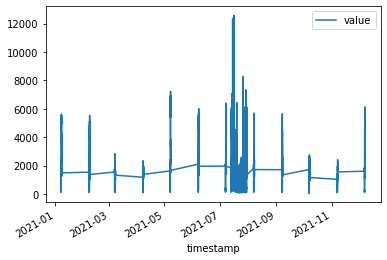

In [6]:
print(df['value'].mean())
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x='timestamp', y='value')


In [8]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [9]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

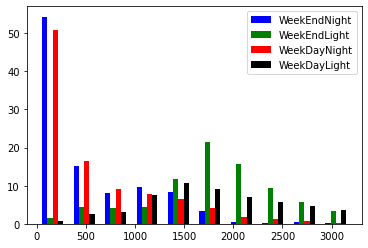

In [10]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

In [11]:
#KNN Trial
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

KeyboardInterrupt: ignored

In [86]:
# choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

14    3996
8     3862
2     3615
3     3529
10    3499
12    3360
4     3360
9     3101
7     3029
0     2924
1     2298
5     2200
6     1927
11    1866
13     634
Name: cluster, dtype: int64

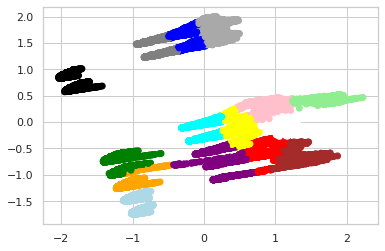

In [87]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [88]:
# return Series of distance between each point and his distance with the closest centroid
#def getDistanceByPoint(data, model):
#    distance = pd.Series()
#    for i in range(0,len(data)):
#        Xa = np.array(data.loc[i])
#        Xb = model.cluster_centers_[model.labels_[i]-1]
#        distance.at[i]=np.linalg.norm(Xa-Xb)
#    return distance
def getDistanceByPoint(data, model):
  distance = pd.Series()
  cluster_cnt = model.labels_.max()
  for i in range(0,len(data)):
    Xa = np.array(data.loc[i])
    dist = []
    for j in range(0,cluster_cnt):
      if model.labels_[i] != j:
        Xb = model.cluster_centers_[j]
        dist.append(np.linalg.norm(Xa-Xb))
    distance.at[i]=min(dist)
  return distance
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance)) #outlier fraction!!!
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


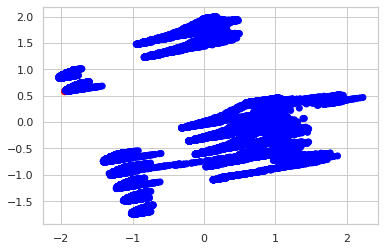

In [89]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

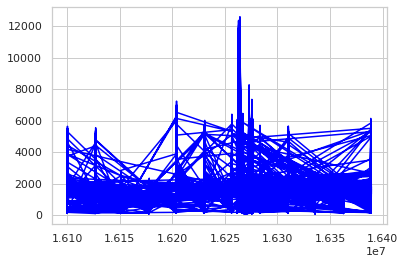

In [90]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



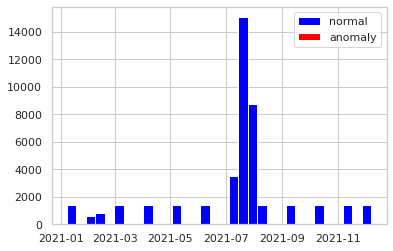

In [133]:
# visualisation of anomaly (viz 2)
a = df.loc[df['anomaly21'] == 0, 'timestamp']
b = df.loc[df['anomaly21'] == 1, 'timestamp']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])

plt.legend()
plt.show()

In [132]:
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value','timestamp','categories']] #anomaly
a.tail()

,time_epoch,value,timestamp,categories
3739,16270880,560,2021-07-24 00:54:00,0
9143,16270882,626,2021-07-24 00:58:00,0
22779,16270919,333,2021-07-24 01:59:00,0
32212,16270877,637,2021-07-24 00:49:00,0


In [25]:
#Isolation Forest Trial
from sklearn.ensemble import IsolationForest
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
# An estimation of anomly population of the dataset (necessary for algorithm)
outliers_fraction = float(.001) #THIS IS IMPORTANT, NEED TO LEARN ABOUT IT MORE AKA HOW TO DETERMINE IT
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

print(df.tail(15))

0    43156
1       44
Name: anomaly25, dtype: int64
       value           timestamp  hours  ...  time_epoch  categories  anomaly25
43185   5085 2021-07-30 12:47:00     12  ...    16276492           3          0
43186   4353 2021-07-30 13:24:00     13  ...    16276514           3          0
43187   4621 2021-07-30 13:44:00     13  ...    16276526           3          0
43188   4938 2021-07-30 13:50:00     13  ...    16276530           3          0
43189   5396 2021-07-30 14:39:00     14  ...    16276559           3          0
43190   5307 2021-07-30 15:10:00     15  ...    16276578           3          0
43191   5222 2021-07-30 15:22:00     15  ...    16276585           3          0
43192   5163 2021-07-30 15:31:00     15  ...    16276590           3          0
43193   5358 2021-07-30 15:57:00     15  ...    16276606           3          0
43194   3846 2021-07-30 17:23:00     17  ...    16276657           3          0
43195   2666 2021-07-30 18:42:00     18  ...    16276705           3

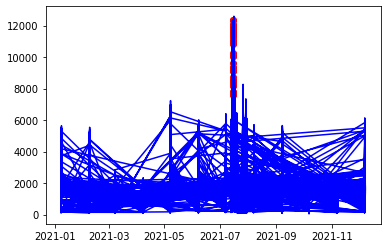

In [26]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['timestamp', 'value']] #anomaly
ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

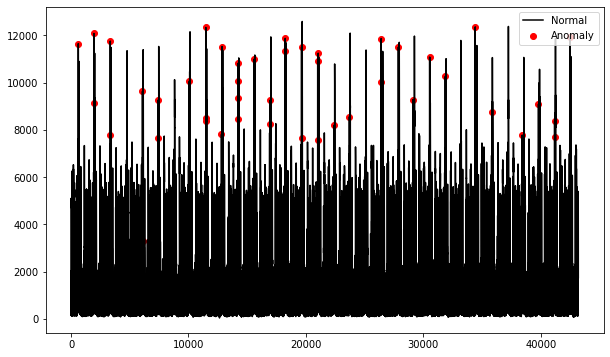

In [30]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly25'] == 1, ['value']] #anomaly
ax.plot(df.index, df['value'], color='black', label = 'Normal', )
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


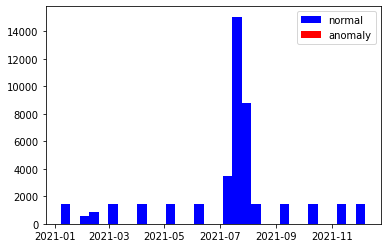

In [40]:
a = df.loc[df['anomaly25'] == 0, 'timestamp']
b = df.loc[df['anomaly25'] == 1, 'timestamp']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

In [38]:
a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value','timestamp','categories']] #anomaly
a.head(10)

,time_epoch,value,timestamp,categories
617,16263088,11655,2021-07-15 00:28:00,2
1946,16263085,12084,2021-07-15 00:22:00,2
1947,16263093,9120,2021-07-15 00:36:00,2
3339,16263075,7773,2021-07-15 00:06:00,2
3340,16263087,11761,2021-07-15 00:26:00,2
6080,16263079,9632,2021-07-15 00:12:00,2
6162,16264801,3285,2021-07-17 00:02:00,0
7394,16263093,9256,2021-07-15 00:35:00,2
7395,16263098,7668,2021-07-15 00:44:00,2
10065,16263080,10054,2021-07-15 00:14:00,2


In [1]:
#classif regre trees (CART)



In [97]:
import seaborn as sns
sns.set_theme(style='whitegrid', palette='muted')
ax = sns.swarmplot(data=df, x='a', y='b', hue='types')
ax.set(ylabel='')


ValueError: ignored

In [41]:
#ONE CLASS SVM 
from sklearn.svm import OneClassSVM

#Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    43160
1       40
Name: anomaly26, dtype: int64


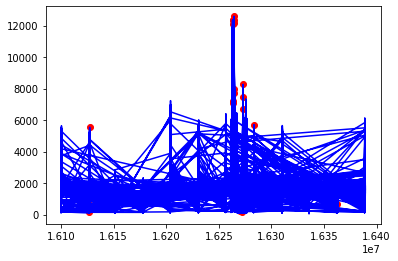

In [42]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


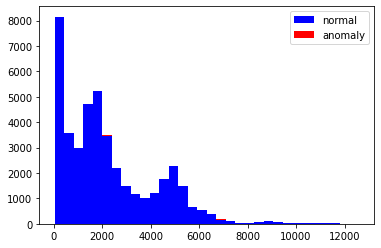

In [43]:
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()